In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Clase y función para crear la capa de z en base a z_mean y z_log_var utilizando el <b>reparameterization trick</b>
###  <b><a href="https://www.youtube.com/watch?v=TQ67J0laA-g">Fuente: Deep Learning Lecture 11.3 - Variational Autoencoder Implementation</a></b> 
![reparameterization](images/Reparametrization-trick.jpg)

In [51]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [52]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [53]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## En la función de entrenamiento no hay epsilon ni tf.keras.backend.random_normal, solo hay optimización de la función de loss, que ahora es determinística.

In [54]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [55]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
vae = VAE(encoder, decoder)

In [56]:
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=600, batch_size=128)

Epoch 1/600
547/547 [==============================] - 7s 11ms/step - loss: 250.4870 - reconstruction_loss: 199.3504 - kl_loss: 3.4460
Epoch 2/600
547/547 [==============================] - 6s 12ms/step - loss: 169.0990 - reconstruction_loss: 161.5267 - kl_loss: 4.9513
Epoch 3/600
547/547 [==============================] - 6s 11ms/step - loss: 161.1652 - reconstruction_loss: 154.7451 - kl_loss: 5.3529
Epoch 4/600
547/547 [==============================] - 6s 11ms/step - loss: 158.0696 - reconstruction_loss: 151.9354 - kl_loss: 5.5318
Epoch 5/600
547/547 [==============================] - 6s 11ms/step - loss: 156.3723 - reconstruction_loss: 150.1901 - kl_loss: 5.6563
Epoch 6/600
547/547 [==============================] - 6s 11ms/step - loss: 154.5731 - reconstruction_loss: 148.6304 - kl_loss: 5.7922
Epoch 7/600
547/547 [==============================] - 6s 11ms/step - loss: 153.9624 - reconstruction_loss: 147.7322 - kl_loss: 5.8760
Epoch 8/600
547/547 [==============================] - 

In [57]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

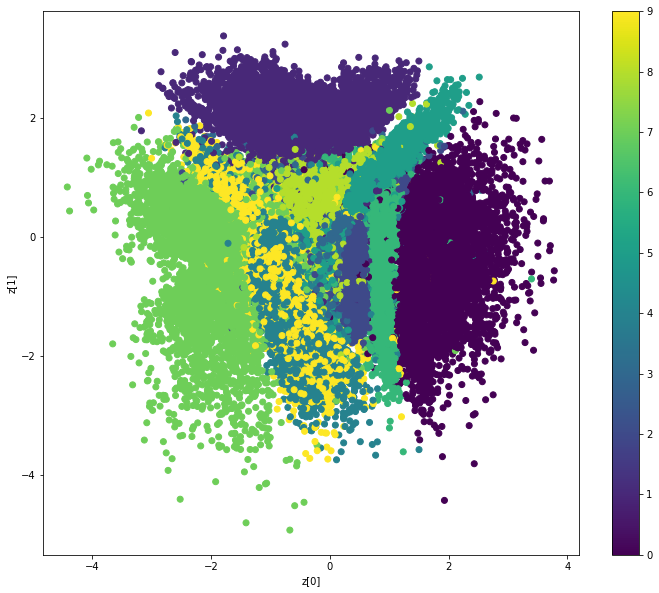

In [58]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Tarea (Parte I)
## 1.	Tome el archivo “3-Variational AutoEncoder” visto y explicado en clase, aplique los cambios necesarios para que el entrenamiento del codificador y decodificador puedan ser salvados y almacenados, tal y como fue comentado en clase.


# Salvo (.save()) por separado los modelos completos del encoder y decoder, no solo los weights por si eventualmente se necesitara algo más
### Se salvan: la arquitectura de los modelos, los pesos, la información de compilación, el optimizador con su estado

In [59]:
encoder.save("./SavedModels/encoder.SavedModel",overwrite=True,include_optimizer=True)
decoder.save("./SavedModels/decoder.SavedModel",overwrite=True,include_optimizer=True)

INFO:tensorflow:Assets written to: ./SavedModels/encoder.SavedModel\assets
INFO:tensorflow:Assets written to: ./SavedModels/decoder.SavedModel\assets


# Tarea (Parte II)
## 2.	Pruebe el código corriendo el algoritmo entrenado usando los codificadores y decodificadores entrenados que fueron salvados y almacenados, esto sin necesidad de tener que volverlos a entrenar, y que puedan realizar las salidas esperadas.

### El backpropagation no puede pasar las gradientes (calcular derivadas) por el proceso estocástico de muestreo. Se utiliza un "Reparameterization trick" sacando el proceso de muestreo, poniéndolo de input del decoder, pero se utiliza un epsilon para multiplicar sobre la desviación estándar, convirtiéndolo en una función determinística, y permitiendo un backpropagation.
### O sea, se vale tener Inputs estocásticos, pero no es posible que gradientes pasen por capas estocásticas, por eso hay que convertirlo en determinístico.
###  <b>Fuente: Rowel Atienza - Advanced Deep Learning with TensorFlow 2 and Keras 2nd Edition (2020), p.260</b> 
![vae](images/vae.png) 

## El código que hice a continuación carga el encoder y decoder, uniéndolos. Se toma únicamente el [2] de recovered_encoder(encoder_inputs)[2] como entrada del decoder.

# Cargo los modelos desde los archivos creados

In [60]:
recovered_encoder = keras.models.load_model("./SavedModels/encoder.SavedModel", compile=False)
recovered_decoder = keras.models.load_model("./SavedModels/decoder.SavedModel", compile=False)

# Ajusto las entradas y las salidas entre el encoder y el decoder

In [61]:
inputs = encoder_inputs
encoder_outputs = recovered_encoder(inputs)[2]
outputs = recovered_decoder(encoder_outputs)

# Analizo las arquitecturas resultantes de los modelos

In [62]:
recovered_vae = keras.models.Model(inputs, outputs, name="VAE")
recovered_encoder.summary()
recovered_decoder.summary()
recovered_vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_7[0][0]                   
____________________________________________________________________________________________

# Genero números pasándolos por el autoencoder variacional completo

In [63]:
xprime_recovered = recovered_vae.predict(mnist_digits)
xprime_original = vae.decoder.predict(vae.encoder.predict(mnist_digits)[2])

# Ploteo las comparaciones entre 10 números originales y los 10 generados correspondientes

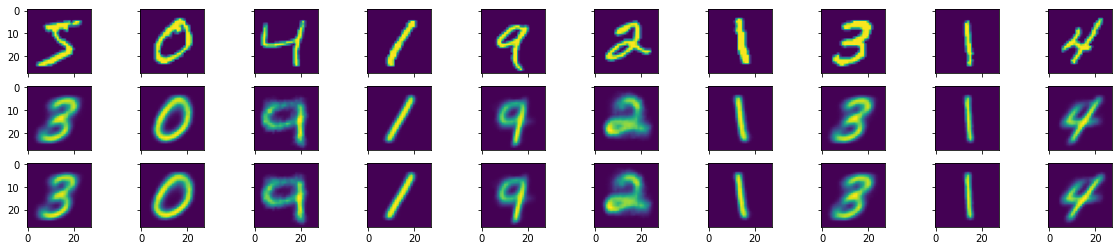

In [64]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
fig, ax = plt.subplots(3, 10, sharex='col', sharey='row')
for i in range(10):
        ax[0,i].imshow(mnist_digits[i]) #<---- Los originales
        ax[1,i].imshow(xprime_recovered[i]) #<---- Los generados por el autoencoder recuperado
        ax[2,i].imshow(xprime_original[i]) #<---- Los generados por el autoencoder original

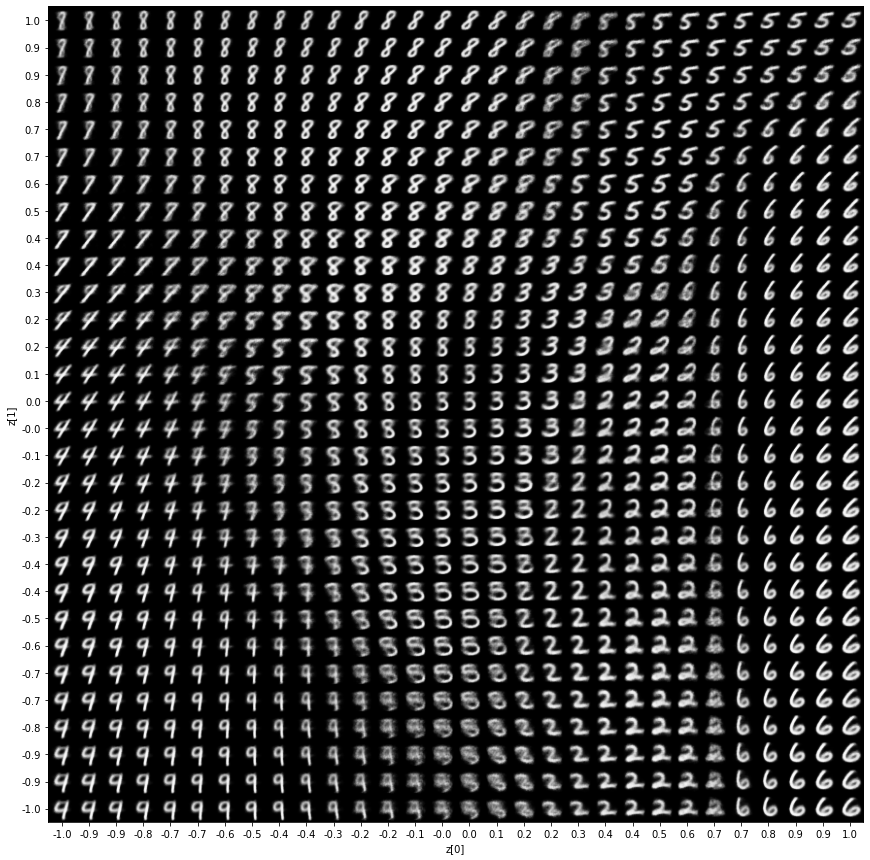

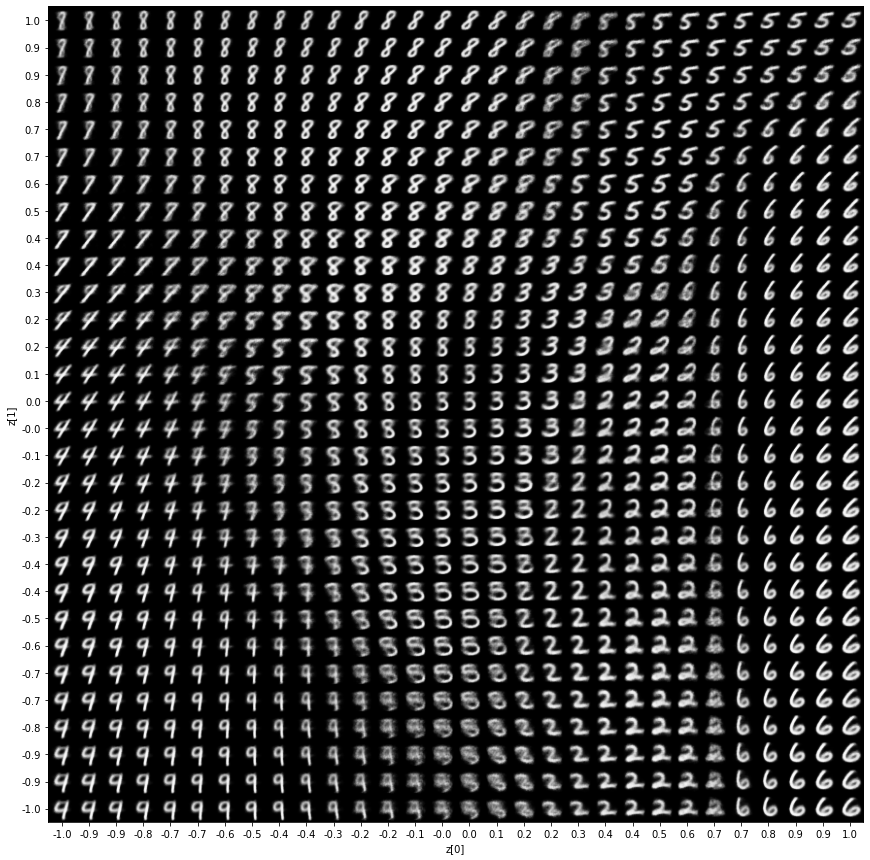

In [65]:
recovered_vae.decoder = recovered_decoder
plot_latent_space(recovered_vae)
plot_latent_space(vae)